In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background'])

# TVD-WENO Scheme

https://www.ams.org/journals/mcom/1998-67-221/S0025-5718-98-00913-2/S0025-5718-98-00913-2.pdf

The TVD second order Runge-Kutta method we consider is the one given in
[12]:
$$u^{(1)} = u^n + ∆tL(u^n)$$,
$$u^{n+1} = 0.5u^n + 0.5u^{(1)} + 1/2∆tL(u^{(1)})$$


Z: 87
0.01569138276553106


Text(0, 0.5, 'z (m)')

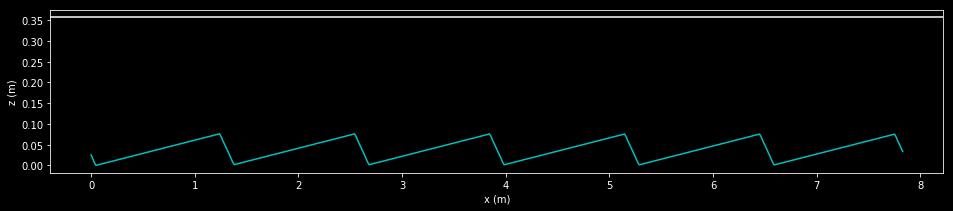

In [2]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)

fig = plt.figure(figsize=(16, 3))
#plt.plot(xc,z0,'b')

dunes = 6

xsaw = np.linspace(0, 1,500)
simTime = 60*10 # Runtime in seconds
dt = 0.5 # Time step size (s)

zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*xc.max()*dunes*0.5
#plt.plot(xsaw,zsaw)


dx = xsaw[1]-xsaw[0]
znew, iterations1 = schemes.avalanche_scheme.avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = schemes.avalanche_scheme.avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew,'-',color='c')
plt.axhline(0.357)
print(dx)
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## Euler-WENO

 Starting simulation....
Number of time steps: 1.0 mins
Grid dx = 0.01569138276553106
Grid nx = 500
Initializing hydrodynamic model...
2019-05-15 15:12:48,592 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 15:13:07,124 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 7.261644476044225e-06
Avalanching!
2019-05-15 15:13:07,185 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 15:13:07,948 INFO CLAW: Solution 1 computed for time t=15.000000
Avalanching!
2019-05-15 15:13:07,984 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 15:13:08,803 INFO CLAW: Solution 1 computed for time t=15.000000
Avalanching!
2019-05-15 15:13:08,909 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 15:13:09,711 INFO CLAW: Solution 1 computed for time t=15.000000
Avalanching!
2019-05-15 15:13:09,741 INFO CLAW: Solution 0 computed for tim

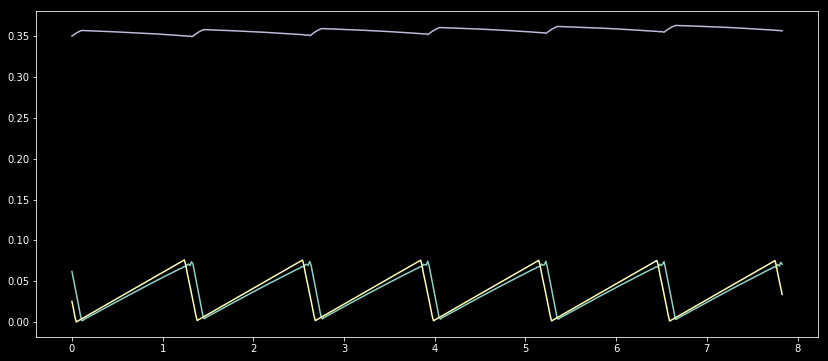

In [21]:
model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = xsaw.copy()
zc = znew.copy()
x0 = xsaw.copy()
z0 = znew.copy()
nx = len(xc)

model.setup_domain(xc, zc, dx)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.247

model.flow_boundary_conditions(q32cm, sOut32)

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.00333
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------

morph_model = sdmodels.EulerWenoModel()
# morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 10.*60       # Runtime in seconds
dt = 10                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1.0


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)

surf = zc + h

plt.plot(xc, surf)


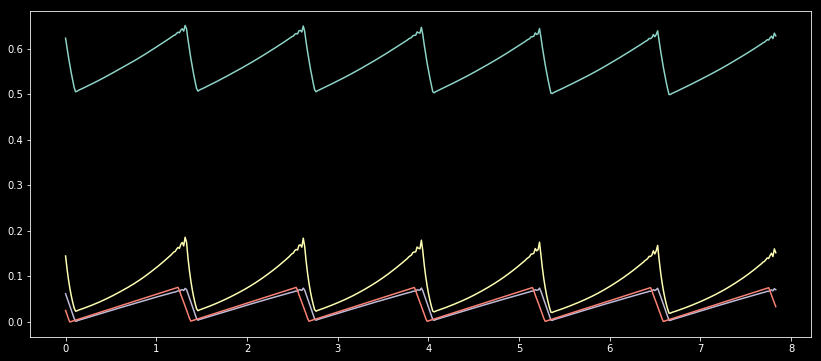

In [22]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,u)
plt.plot(xc,qbedload*30000.)
plt.plot(xc,zc)
plt.plot(x0,z0)

In [23]:
model._wave_speed, model._wave_length, model._wave_height

({60: 0.1569138276553106,
  120: 0.1569138276553106,
  180: 0.17260521042084165,
  240: 0.17260521042084165,
  300: 0.1882965931863727,
  360: 0.1882965931863727,
  420: 0.20398797595190377,
  480: 0.20398797595190377,
  540: 0.21967935871743483},
 {60: 3.9385370741482957,
  120: 3.9385370741482957,
  180: 3.9385370741482957,
  240: 3.9385370741482957,
  300: 3.9479519038076147,
  360: 3.9385370741482957,
  420: 3.9448136272545087,
  480: 3.9385370741482957,
  540: 3.941675350701402},
 {60: 0.07400091030526305,
  120: 0.0754680040676643,
  180: 0.0718631631726819,
  240: 0.07226198289366943,
  300: 0.07104479359605077,
  360: 0.0711775240699167,
  420: 0.0690255150165732,
  480: 0.06903071543168993,
  540: 0.06820795578550855})

In [55]:
wavehdf = pd.DataFrame.from_dict(model._wave_height, 
                                orient='index',columns=['height'])

waveldf = pd.DataFrame.from_dict(model._wave_length, 
                                orient='index',columns=['length'])

wavesdf = pd.DataFrame.from_dict(model._wave_speed, 
                                orient='index',columns=['speed'])

waveDf = pd.concat([wavehdf, waveldf, wavesdf], axis=1)

In [56]:
waveDf

,height,length,speed
60,0.074001,3.938537,0.156914
120,0.075468,3.938537,0.156914
180,0.071863,3.938537,0.172605
240,0.072262,3.938537,0.172605
300,0.071045,3.947952,0.188297
360,0.071178,3.938537,0.188297
420,0.069026,3.944814,0.203988
480,0.069031,3.938537,0.203988
540,0.068208,3.941675,0.219679


## TVD-WENO

 Starting simulation....
Number of time steps: 3.0 mins
Grid dx = 0.01569138276553106
Grid nx = 500
Initializing hydrodynamic model...
2019-05-15 16:10:48,544 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 16:11:12,834 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 6.2233493062552145e-06
2019-05-15 16:11:12,869 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 16:11:13,435 INFO CLAW: Solution 1 computed for time t=10.000000
Avalanching!
2019-05-15 16:11:13,469 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 16:11:14,184 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-15 16:11:14,211 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 16:11:14,712 INFO CLAW: Solution 1 computed for time t=10.000000
Avalanching!
2019-05-15 16:11:14,762 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-15 1

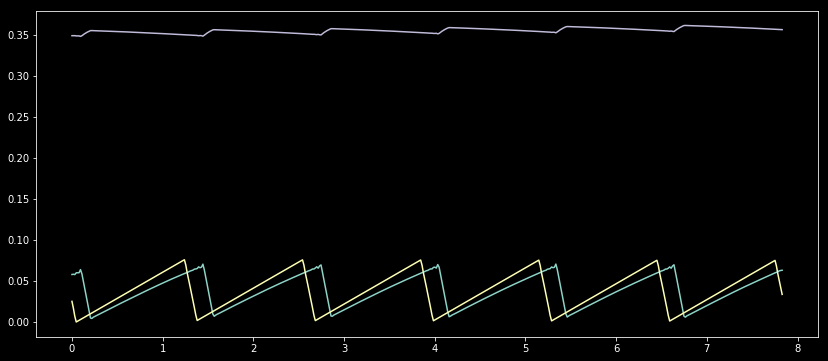

In [58]:
#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.00333
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------

morph_model = sdmodels.TVD2ndWenoModel()
# morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 15.*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)

surf = zc + h

plt.plot(xc, surf)

In [25]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(-1*z0, height=-0.02)

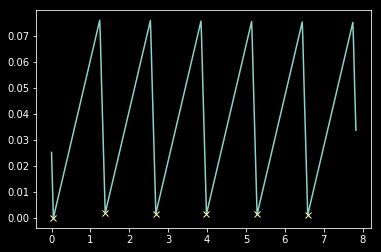

In [26]:
plt.plot(xc,z0)
plt.plot(xc[peaks], z0[peaks], "x")

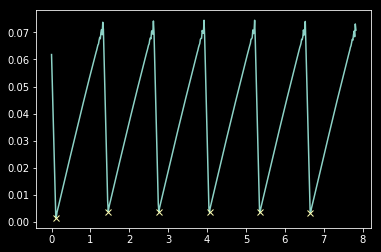

In [27]:
peaks, _ = find_peaks(-1*zc, height=-0.02)
plt.plot(xc,zc)
plt.plot(xc[peaks], zc[peaks], "x")

for peak in peaks:
    print(peak)

In [48]:
model._peak1

array([ 79, 162, 245, 328, 411, 494])